# Анализ настроения комментарий из социальной сети Вконтакте.

In [1]:
from webapp import create_app
from vk_parser import *
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import SnowballStemmer
import pymorphy2
import joblib
from time import time
import seaborn as sns
from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import MinMaxScaler
import gensim 
print("gensim", gensim.__version__)
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import common_texts
from gensim.sklearn_api import D2VTransformer
import logging
%matplotlib inline

gensim 3.8.3


# Обработка текста.

- Обработка текста через регулярные выражения.
- Удаление всех url из текста.
- Удаление хэштегов, если они есть в тексте.
- Удаление имён пользователей.
- Удаление пунктуации и цифр.
- Приведение всего текста к нижнему регистру.

In [2]:
def preprocess_text(text):
    text = text.lower().replace('ё', 'е')
    text = text.replace('d', '')
    text = text.replace('rt', '')
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', text)
    text = re.sub('@[^\s]+', '', text)
    text = re.sub(r'[a-zA-Z]', '', text)
    text = re.sub(r'\b[a-zA-Zа-яА-Я1-9]\b', '', text)
    text = re.sub(r'\b(?:[аевзпхщчоумы][аиеоузпхщчмы]+)+\b', '', text)
    text = re.sub(r'[0-9]', '', text)    
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()

# Предобработка текста.

- Используем корпус Юлии Рубцовой русских твитов для тренировки модели.
- Скачиваем корпус позитивных и негативных твитов с сайта http://study.mokoron.com/
- Добавляем дополнительную колонку для позитивных (1) и негативных твитов (0), тем самым размечая данные.

In [14]:
# Считываем данные
n = ['id', 'date', 'name', 'text', 'typr', 'rep', 'rtw', 'faw', 'stcount', 'foll', 'frien', 'listcount']
data_positive = pd.read_csv('training_data/positive.csv', sep=';', error_bad_lines=False, names=n, usecols=['text'])
data_negative = pd.read_csv('training_data/negative.csv', sep=';', error_bad_lines=False, names=n, usecols=['text'])

# Формируем сбалансированный датасет
sample_size = min(data_positive.shape[0], data_negative.shape[0])

raw_data = np.concatenate((data_positive['text'].values[:sample_size],
                           data_negative['text'].values[:sample_size]), axis=0)
labels = [1] * sample_size + [0] * sample_size

In [15]:
app = create_app()
with app.app_context():
    query = Comment.query.all()
    preprop_comm = []

    for comment in query:
        preprop_comm.append(preprocess_text(comment.comment_text))

In [2]:
phrase = 'Привет! Очень понравилось. ШИкарный фильм.'
phrase2 = 'вообще жесть! отвратительно!'

In [3]:
def conveyor(text):
    stop_words = set(stopwords.words("russian"))
    morph = pymorphy2.MorphAnalyzer()
    tfidf_vect = joblib.load('tfidf_vect.pkl')
    text = preprocess_text(text)
    tokens = word_tokenize(text)
    text = delete_stop_words_with_lemmatizing(tokens, morph, stop_words)
    text = ' '.join(text)
    text_to_list=[]
    text_to_list.append(text)
    tfidf_text = tfidf_vect.transform(text_to_list) 
    return tfidf_text

In [59]:
X_test = conveyor(phrase)

2021-01-24 16:10:59,861 : INFO : Loading dictionaries from C:\Users\kamikaze666\Anaconda3\envs\tf_gpu\lib\site-packages\pymorphy2_dicts_ru\data
2021-01-24 16:10:59,911 : INFO : format: 2.4, revision: 417127, updated: 2020-10-11T15:05:51.070345


In [ ]:
X_test2 = conveyor(phrase2)

In [60]:
X_test.shape

(5, 91962)

In [17]:
data = [preprocess_text(t) for t in raw_data]

In [18]:
bd_data = [preprocess_text(t) for t in preprop_comm]

In [19]:
print(len(labels), len(raw_data), len(data))

223846 223846 223846


In [20]:
print(len(bd_data))

1220


- Скачиваем набор русских стоп-слов для предобработки наших твитов.

In [21]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kamikaze666\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kamikaze666\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

- Разбиваем предобработанные слова на токены.
- Удаляем стоп слова.
- Производим лемматизацию или стемминг текста.
- Удаляем короткие слова длинной меньше 2 символов.

In [22]:
def tokenaizer(data):
    tokens = [word_tokenize(sent) for sent in data]
    return tokens

In [23]:
tokenized_data = tokenaizer(data)

In [24]:
print(len(tokenized_data))

223846


In [91]:
bd_tokenized_data = tokenaizer(bd_data)

In [92]:
print(len(bd_tokenized_data))

1220


# Стемминг слов

In [7]:
def stemmer(word, stem_init):
    return stem_init.stem(str(word))

In [8]:
def delete_stop_words_with_stemming(words, stop_words):    
    default_list = []
    for word in words:
        if word not in stop_words:
            stemmed_word = stemmer(word, snowball)
            default_list.append(stemmed_word)

    return list(default_list)

In [46]:
stop_words = set(stopwords.words("russian"))
snowball = SnowballStemmer(language="russian")
stemmed_words = []
counter = 0
for part_of_list in tokenized_data:
    stemmed_words.append(delete_stop_words_with_stemming(part_of_list, stop_words))
    counter += 1
    if counter%10000 == 0:
        print("Processed {} of {}".format(counter, len(part_of_list)))

Processed 10000 of 11
Processed 20000 of 10
Processed 30000 of 9
Processed 40000 of 5
Processed 50000 of 9
Processed 60000 of 9
Processed 70000 of 4
Processed 80000 of 7
Processed 90000 of 18
Processed 100000 of 12
Processed 110000 of 8
Processed 120000 of 8
Processed 130000 of 10
Processed 140000 of 10
Processed 150000 of 8
Processed 160000 of 14
Processed 170000 of 9
Processed 180000 of 12
Processed 190000 of 11
Processed 200000 of 17
Processed 210000 of 18
Processed 220000 of 5


# Лемматизация слов.

"Экземпляры класса MorphAnalyzer обычно занимают порядка 15Мб оперативной памяти (т.к. загружают в память словари, данные для предсказателя и т.д.); старайтесь организовать свой код так, чтобы создавать экземпляр MorphAnalyzer заранее и работать с этим единственным экземпляром в дальнейшем."

https://pymorphy2.readthedocs.io/en/latest/user/guide.html

In [94]:
def delete_stop_words_with_lemmatizing(words, morph, stop_words):  
    default_list = []
    for word in words:
        if word not in stop_words:
            lem_word = morph.parse(str(word))[0].normal_form
            default_list.append(lem_word)
    return list(default_list)

In [95]:
stop_words = set(stopwords.words("russian"))
morph = pymorphy2.MorphAnalyzer()
lemmatized_words = []
counter = 0
for part_of_list in tokenized_data:
    lemmatized_words.append(delete_stop_words_with_lemmatizing(part_of_list, morph, stop_words))   
    counter += 1
    if counter%10000 == 0:
        print("Processed {} of {}".format(counter, len(part_of_list)))

2021-01-24 16:29:35,631 : INFO : Loading dictionaries from C:\Users\kamikaze666\Anaconda3\envs\tf_gpu\lib\site-packages\pymorphy2_dicts_ru\data
2021-01-24 16:29:35,682 : INFO : format: 2.4, revision: 417127, updated: 2020-10-11T15:05:51.070345


Processed 10000 of 11
Processed 20000 of 10
Processed 30000 of 9
Processed 40000 of 5
Processed 50000 of 9
Processed 60000 of 9
Processed 70000 of 4
Processed 80000 of 7
Processed 90000 of 18
Processed 100000 of 12
Processed 110000 of 8
Processed 120000 of 8
Processed 130000 of 10
Processed 140000 of 10
Processed 150000 of 8
Processed 160000 of 14
Processed 170000 of 9
Processed 180000 of 12
Processed 190000 of 11
Processed 200000 of 17
Processed 210000 of 18
Processed 220000 of 5


In [96]:
bd_lemmatized_words = []
counter = 0
for part_of_list in bd_tokenized_data:
    bd_lemmatized_words.append(delete_stop_words_with_lemmatizing(part_of_list, morph, stop_words))   
    counter += 1
    if counter%1000 == 0:
        print("Processed {} of {}".format(counter, len(part_of_list)))
        
bd_lemmatized_words = [x for x in bd_lemmatized_words if x != []] #удалил пустые списки после лемматизации

Processed 1000 of 2


# Добавляем наши списки слов в pandas DataFrame.

In [97]:
def to_data_frame(data, labels):
    default_list = []
    
    
    for string in data:
        new_string = ' '.join(string)
        default_list.append(new_string)
    
    
    default_list = pd.DataFrame(list(zip(default_list, labels)), columns =['comments', 'sentiment'])
    return default_list

In [51]:
default_list = []
for string in bd_lemmatized_words:
    new_string = ' '.join(string)
    default_list.append(new_string)
    
df_bd_lemmatized_words = pd.DataFrame(list(default_list), columns =['comments']) 

In [52]:
df_stemmed_words = to_data_frame(stemmed_words, labels)

In [53]:
df_lemmatized_words = to_data_frame(lemmatized_words, labels)

In [54]:
df_lemmatized_words.head()

,comments,sentiment
0,школотый поверь самый общество профилировать п...,1
1,таки немного похожий мальчик равно,1
2,идиотка испугаться,1
3,угол сидеть погибать голод порция взять хотя ж...,1
4,значит страшилка блин посмотреть часть создать...,1


- сохраним наш датасет

In [25]:
df_lemmatized_words.to_csv('lemmatized_words.csv', index=False, encoding='cp1251')

In [26]:
df_stemmed_words.to_csv('stemmed_words.csv', index=False, encoding='cp1251')

In [27]:
df_bd_lemmatized_words.to_csv('X_test.csv', index=False, encoding='cp1251')

- загрузим наш датасет

In [28]:
df_lemmatized_words = pd.read_csv('lemmatized_words.csv', encoding='cp1251')

In [29]:
df_stemmed_words = pd.read_csv('stemmed_words.csv', encoding='cp1251')

In [30]:
df_bd_lemmatized_words = pd.read_csv('X_test.csv', encoding='cp1251')

# Word embedding (Векторное представление слов)

- Сделаем векторизацию текста 4-мя способами BoW, TF-IDF, Word2Vec, doc2vec.
- На этих данных обучим модели и сравним результаты.

# Bag Of Words (BoW).

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

In [27]:
bow_vectorizer = CountVectorizer()
bow_x_train = bow_vectorizer.fit_transform(df_lemmatized_words['comments'].values.astype('U'))
bow_x_test = bow_vectorizer.transform(df_bd_lemmatized_words['comments'].values.astype('U'))

In [30]:
joblib.dump(bow_vectorizer, 'bow_vectorizer.pkl')

['bow_vectorizer.pkl']

In [28]:
bow_vectorizer = joblib.load('bow_vectorizer.pkl')
bow_x_train = bow_vectorizer.fit_transform(df_lemmatized_words['comments'].values.astype('U'))
bow_x_test = bow_vectorizer.transform(df_bd_lemmatized_words['comments'].values.astype('U'))

In [29]:
print(bow_x_train.shape)

(223846, 91961)


# Bag Of Word with n-grams.

In [32]:
ngram_vectorizer = CountVectorizer(ngram_range=(2, 2))
ngram_x_train = ngram_vectorizer.fit_transform(df_lemmatized_words['comments'].values.astype('U'))
ngram_x_test = ngram_vectorizer.transform(df_bd_lemmatized_words['comments'].values.astype('U'))
joblib.dump(ngram_vectorizer, 'ngram_vectorizer.pkl')

['ngram_vectorizer.pkl']

In [19]:
ngram_vectorizer = joblib.load('ngram_vectorizer.pkl')
ngram_x_train = ngram_vectorizer.fit_transform(df_lemmatized_words['comments'].values.astype('U'))
ngram_x_test = ngram_vectorizer.transform(df_bd_lemmatized_words['comments'].values.astype('U'))

In [33]:
print(ngram_x_train.shape)

(223846, 754286)


- Вывод: 
  - Потеря порядка слов;
  - Полученные вектора, не являются информативными и занимают очень много места в памяти;

# TF-IDF.

(TF — term frequency, IDF — inverse document frequency) — статистическая мера, используемая для оценки важности слова в контексте документа, являющегося частью коллекции документов или корпуса.

In [67]:
def vectorize(data,tfidf_vect_fit):
    X_tfidf = tfidf_vect_fit.transform(data)
    words = tfidf_vect_fit.get_feature_names()
    X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
    X_tfidf_df.columns = words
    return(X_tfidf_df)

tfidf_vect = TfidfVectorizer()

tfidf_vect_train = tfidf_vect.fit_transform(df_lemmatized_words['comments'].values.astype('U'))
tfidf_vect_test = tfidf_vect.transform(df_bd_lemmatized_words['comments'].values.astype('U'))

In [68]:
joblib.dump(tfidf_vect_train, 'tfidf_vect_train.pkl')

['tfidf_vect_train.pkl']

In [69]:
joblib.dump(tfidf_vect, 'tfidf_vect.pkl')

['tfidf_vect.pkl']

In [70]:
tfidf_vect = joblib.load('tfidf_vect.pkl')
tfidf_vect_train = joblib.load('tfidf_vect_train.pkl')

In [71]:
tfidf_vect_train.shape

(223846, 91962)

In [72]:
tfidf_vect_test.shape

(1070, 91962)

# Word2Vec для предложений.

In [34]:
from gensim.models import Word2Vec
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [38]:
num_features = 1000  # Word vector dimensionality
min_word_count = 40 # Minimum word count
num_workers = 7     # Number of parallel threads
context = 10        # Context window size
downsampling = 1e-3 # (0.001) Downsample setting for frequent words

In [39]:
df_lemmatized_words['comments'].head()

0    школотый поверь самый общество профилировать п...
1                   таки немного похожий мальчик равно
2                                   идиотка испугаться
3    угол сидеть погибать голод порция взять хотя ж...
4    значит страшилка блин посмотреть часть создать...
Name: comments, dtype: object

In [40]:
print("Training model....")
w2v_vectorizer = Word2Vec(lemmatized_words, #пихаем сюда список списков наших слов
                          workers=num_workers,
                          size=num_features,
                          min_count=min_word_count,
                          window=context,
                          sample=downsampling)

# To make the model memory efficient
w2v_vectorizer.init_sims(replace=True)

# Saving the model for later use. Can be loaded using Word2Vec.load()
model_name = "1000features_40minwords_10context"
w2v_vectorizer.save(model_name)

2021-01-23 11:06:16,899 : INFO : collecting all words and their counts
2021-01-23 11:06:16,901 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-01-23 11:06:16,920 : INFO : PROGRESS: at sentence #10000, processed 65179 words, keeping 14918 word types
2021-01-23 11:06:16,942 : INFO : PROGRESS: at sentence #20000, processed 128674 words, keeping 22840 word types
2021-01-23 11:06:16,963 : INFO : PROGRESS: at sentence #30000, processed 194264 words, keeping 29236 word types
2021-01-23 11:06:16,990 : INFO : PROGRESS: at sentence #40000, processed 258322 words, keeping 34598 word types
2021-01-23 11:06:17,012 : INFO : PROGRESS: at sentence #50000, processed 322449 words, keeping 39565 word types
2021-01-23 11:06:17,036 : INFO : PROGRESS: at sentence #60000, processed 386089 words, keeping 44137 word types
2021-01-23 11:06:17,058 : INFO : PROGRESS: at sentence #70000, processed 450981 words, keeping 48675 word types
2021-01-23 11:06:17,084 : INFO : PROGRESS: at s

Training model....


2021-01-23 11:06:17,106 : INFO : PROGRESS: at sentence #90000, processed 578376 words, keeping 56391 word types
2021-01-23 11:06:17,130 : INFO : PROGRESS: at sentence #100000, processed 643840 words, keeping 59888 word types
2021-01-23 11:06:17,152 : INFO : PROGRESS: at sentence #110000, processed 707136 words, keeping 63221 word types
2021-01-23 11:06:17,174 : INFO : PROGRESS: at sentence #120000, processed 768653 words, keeping 66362 word types
2021-01-23 11:06:17,197 : INFO : PROGRESS: at sentence #130000, processed 829112 words, keeping 69081 word types
2021-01-23 11:06:17,236 : INFO : PROGRESS: at sentence #140000, processed 890601 words, keeping 71841 word types
2021-01-23 11:06:17,259 : INFO : PROGRESS: at sentence #150000, processed 951762 words, keeping 74459 word types
2021-01-23 11:06:17,283 : INFO : PROGRESS: at sentence #160000, processed 1013405 words, keeping 76940 word types
2021-01-23 11:06:17,308 : INFO : PROGRESS: at sentence #170000, processed 1074752 words, keeping

In [62]:
w2v_vectorizer = Word2Vec.load("1000features_40minwords_10context")

2021-01-24 15:36:57,499 : INFO : loading Word2Vec object from 1000features_40minwords_10context
2021-01-24 15:36:57,837 : INFO : loading wv recursively from 1000features_40minwords_10context.wv.* with mmap=None
2021-01-24 15:36:57,838 : INFO : setting ignored attribute vectors_norm to None
2021-01-24 15:36:57,838 : INFO : loading vocabulary recursively from 1000features_40minwords_10context.vocabulary.* with mmap=None
2021-01-24 15:36:57,839 : INFO : loading trainables recursively from 1000features_40minwords_10context.trainables.* with mmap=None
2021-01-24 15:36:57,840 : INFO : setting ignored attribute cum_table to None
2021-01-24 15:36:57,841 : INFO : loaded 1000features_40minwords_10context


In [63]:
w2v_vectorizer.wv.doesnt_match("мужик король парень мама".split())

2021-01-24 15:37:02,877 : INFO : precomputing L2-norms of word weight vectors
C:\Users\kamikaze666\Anaconda3\envs\tf_gpu\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'мама'

In [64]:
w2v_vectorizer.wv.most_similar("парень")

[('девушка', 0.8949131369590759),
 ('подруга', 0.8338074684143066),
 ('бывший', 0.8086804747581482),
 ('знакомый', 0.7963434457778931),
 ('влюбиться', 0.7873918414115906),
 ('встречаться', 0.7791797518730164),
 ('мужчина', 0.7780450582504272),
 ('девочка', 0.7761287689208984),
 ('баба', 0.7749335169792175),
 ('познакомиться', 0.750684916973114)]

In [65]:
w2v_vectorizer.wv.vectors.shape

(4204, 1000)

- Функция для усреднения всех векторов слов в абзаце.

In [58]:
def featureVecMethod(words, model, num_features):
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
    index2word_set = set(model.wv.index2word)
    
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model.wv[word])

    featureVec = np.divide(featureVec, nwords)
    return featureVec

- Функция вычисления среднего вектора признаков.

In [59]:
def getAvgFeatureVecs(reviews, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        if counter%1000 == 0:
            print("Review %d of %d"%(counter,len(reviews)))
            
        reviewFeatureVecs[counter] = featureVecMethod(review, model, num_features)
        counter = counter+1
        
    return reviewFeatureVecs

In [46]:
w2v_X_train = getAvgFeatureVecs(lemmatized_words, w2v_vectorizer, num_features)

Review 0 of 223846
Review 1000 of 223846


<ipython-input-44-907d822aa921>:11: RuntimeWarning: invalid value encountered in true_divide
  featureVec = np.divide(featureVec, nwords)


Review 2000 of 223846
Review 3000 of 223846
Review 4000 of 223846
Review 5000 of 223846
Review 6000 of 223846
Review 7000 of 223846
Review 8000 of 223846
Review 9000 of 223846
Review 10000 of 223846
Review 11000 of 223846
Review 12000 of 223846
Review 13000 of 223846
Review 14000 of 223846
Review 15000 of 223846
Review 16000 of 223846
Review 17000 of 223846
Review 18000 of 223846
Review 19000 of 223846
Review 20000 of 223846
Review 21000 of 223846
Review 22000 of 223846
Review 23000 of 223846
Review 24000 of 223846
Review 25000 of 223846
Review 26000 of 223846
Review 27000 of 223846
Review 28000 of 223846
Review 29000 of 223846
Review 30000 of 223846
Review 31000 of 223846
Review 32000 of 223846
Review 33000 of 223846
Review 34000 of 223846
Review 35000 of 223846
Review 36000 of 223846
Review 37000 of 223846
Review 38000 of 223846
Review 39000 of 223846
Review 40000 of 223846
Review 41000 of 223846
Review 42000 of 223846
Review 43000 of 223846
Review 44000 of 223846
Review 45000 of 223

In [47]:
w2v_X_train .shape

(223846, 1000)

In [48]:
w2v_X_test  = getAvgFeatureVecs(bd_lemmatized_words, w2v_vectorizer, num_features)

Review 0 of 1070
Review 1000 of 1070


<ipython-input-44-907d822aa921>:11: RuntimeWarning: invalid value encountered in true_divide
  featureVec = np.divide(featureVec, nwords)


In [49]:
w2v_X_test.shape

(1070, 1000)

# Doc2Vec.

In [51]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import common_texts
from gensim.sklearn_api import D2VTransformer

tagged_data = [TaggedDocument(d, tags=[str(i)]) for i, d in enumerate(lemmatized_words)]

2021-01-23 11:08:49,003 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-01-23 11:08:49,005 : INFO : built Dictionary(12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...) from 9 documents (total 29 corpus positions)


In [52]:
import gensim; print("gensim", gensim.__version__)

gensim 3.8.3


In [53]:
d2v_model = D2VTransformer(vector_size=20,
                           alpha=0.025, 
                           min_alpha=0.00025,
                           min_count=1,
                           dm =1,
                           workers=7)

d2v_test = d2v_model.fit_transform(tagged_data)

TypeError: __init__() got an unexpected keyword argument 'vector_size'

In [54]:
max_epochs = 50
vec_size = 20
alpha = 0.025

d2v_vectorizer = Doc2Vec(vector_size=vec_size,
                         alpha=alpha, 
                         min_alpha=0.00025,
                         min_count=1,
                         dm =1,
                         workers=7)
  
d2v_vectorizer.build_vocab(tagged_data)

2021-01-23 11:08:59,187 : INFO : collecting all words and their counts
2021-01-23 11:08:59,189 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2021-01-23 11:08:59,227 : INFO : PROGRESS: at example #10000, processed 65179 words (1734235/s), 14918 word types, 10000 tags
2021-01-23 11:08:59,265 : INFO : PROGRESS: at example #20000, processed 128674 words (1752882/s), 22840 word types, 20000 tags
2021-01-23 11:08:59,308 : INFO : PROGRESS: at example #30000, processed 194264 words (1578526/s), 29236 word types, 30000 tags
2021-01-23 11:08:59,344 : INFO : PROGRESS: at example #40000, processed 258322 words (1819410/s), 34598 word types, 40000 tags
2021-01-23 11:08:59,387 : INFO : PROGRESS: at example #50000, processed 322449 words (1537740/s), 39565 word types, 50000 tags
2021-01-23 11:08:59,438 : INFO : PROGRESS: at example #60000, processed 386089 words (1248523/s), 44137 word types, 60000 tags
2021-01-23 11:08:59,484 : INFO : PROGRESS: at example #70000, pr

In [57]:
for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    d2v_vectorizer.train(tagged_data,
                         total_examples=d2v_vectorizer.corpus_count,
                         epochs=d2v_vectorizer.epochs)
    # decrease the learning rate
    d2v_vectorizer.alpha -= 0.0002
    # fix the learning rate, no decay
    d2v_vectorizer.min_alpha = d2v_vectorizer.alpha

d2v_vectorizer.save("d2v.model")
print("doc2vec_vectorizer Saved")

2021-01-21 21:40:20,414 : INFO : training model with 8 workers on 91982 vocabulary and 20 features, using sg=0 hs=0 sample=0.001 negative=5 window=5


iteration 0


2021-01-21 21:40:21,622 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 9363 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:40:22,805 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 42273 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:40:23,985 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 53345 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:40:25,156 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 59013 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:40:26,378 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 61911 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:40:27,593 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 63819 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:40:28,786 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 65375 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:40:30,008 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 66348 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:40:31,330 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 66467 words/s, in_qsize 15

2021-01-21 21:41:28,444 : INFO : EPOCH - 3 : training on 1398936 raw words (1566252 effective words) took 23.0s, 68173 effective words/s
2021-01-21 21:41:29,673 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 9112 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:41:30,737 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 43904 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:41:31,946 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 54268 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:41:33,156 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 59289 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:41:34,420 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 61699 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:41:35,706 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 63044 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:41:37,022 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 63763 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:41:38,300 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 64

iteration 1


2021-01-21 21:42:15,319 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 9231 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:42:16,505 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 41906 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:42:17,686 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 53028 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:42:18,928 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 57907 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:42:20,190 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 60562 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:42:21,487 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 61988 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:42:22,697 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 63628 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:42:24,018 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 64142 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:42:25,270 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 64924 words/s, in_qsize 16

2021-01-21 21:43:22,896 : INFO : EPOCH - 3 : training on 1398936 raw words (1566241 effective words) took 22.9s, 68470 effective words/s
2021-01-21 21:43:24,137 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 9094 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:43:25,395 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 40417 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:43:26,657 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 50634 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:43:27,878 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 56193 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:43:29,188 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 58692 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:43:30,447 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 60700 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:43:31,695 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 62230 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:43:33,011 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 62

iteration 2


2021-01-21 21:44:09,654 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 9502 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:44:10,864 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 42176 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:44:12,031 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 53461 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:44:13,207 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 59067 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:44:14,498 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 61223 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:44:15,815 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 62370 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:44:17,182 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 62814 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:44:18,621 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 62698 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:44:19,898 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 63478 words/s, in_qsize 16

2021-01-21 21:45:16,203 : INFO : EPOCH - 3 : training on 1398936 raw words (1566369 effective words) took 22.4s, 69795 effective words/s
2021-01-21 21:45:17,396 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 9639 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:45:18,611 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 42320 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:45:19,827 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 52860 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:45:21,164 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 56673 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:45:22,532 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 58551 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:45:23,805 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 60455 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:45:25,038 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 62106 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:45:26,264 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 63

iteration 3


2021-01-21 21:46:02,616 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 9198 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:46:03,877 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 40572 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:46:05,082 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 51555 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:46:06,247 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 57610 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:46:07,484 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 60580 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:46:08,749 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 62273 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:46:09,953 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 63933 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:46:11,290 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 64304 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:46:12,527 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 65149 words/s, in_qsize 15

2021-01-21 21:47:09,242 : INFO : EPOCH - 3 : training on 1398936 raw words (1566020 effective words) took 22.5s, 69556 effective words/s
2021-01-21 21:47:10,452 : INFO : EPOCH 4 - PROGRESS: at 0.67% examples, 9268 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:47:11,685 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 41132 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:47:12,922 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 51589 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:47:14,168 : INFO : EPOCH 4 - PROGRESS: at 17.32% examples, 56688 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:47:15,509 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 58808 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:47:16,728 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 61132 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:47:17,965 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 62688 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:47:19,205 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 63

iteration 4


2021-01-21 21:47:56,146 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 9379 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:47:57,331 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 42262 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:47:58,476 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 53870 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:47:59,639 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 59597 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:48:00,899 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 61991 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:48:02,135 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 63720 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:48:03,480 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 64125 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:48:04,712 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 65174 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:48:05,974 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 65790 words/s, in_qsize 15

2021-01-21 21:49:04,313 : INFO : EPOCH - 3 : training on 1398936 raw words (1566062 effective words) took 23.6s, 66481 effective words/s
2021-01-21 21:49:05,621 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 8535 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:49:06,920 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 38572 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:49:08,114 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 49959 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:49:09,294 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 56092 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:49:10,553 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 59070 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:49:11,786 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 61246 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:49:12,993 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 62999 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:49:14,220 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 64

iteration 5


2021-01-21 21:49:50,728 : INFO : EPOCH 1 - PROGRESS: at 1.36% examples, 21011 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:49:51,932 : INFO : EPOCH 1 - PROGRESS: at 6.21% examples, 44325 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:49:53,087 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 55386 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:49:54,259 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 60716 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:49:55,558 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 62473 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:49:56,782 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 64234 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:49:57,994 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 65587 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:49:59,221 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 66495 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:50:00,484 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 66961 words/s, in_qsize 1

2021-01-21 21:50:58,775 : INFO : EPOCH - 3 : training on 1398936 raw words (1565944 effective words) took 23.5s, 66735 effective words/s
2021-01-21 21:50:59,904 : INFO : EPOCH 4 - PROGRESS: at 0.70% examples, 10106 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:51:01,110 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 43305 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:51:02,304 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 53996 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:51:03,528 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 58898 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:51:04,849 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 60788 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:51:06,127 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 62317 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:51:07,384 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 63585 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:51:08,643 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 6

iteration 6


2021-01-21 21:51:45,954 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 8762 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:51:47,245 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 39178 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:51:48,541 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 49154 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:51:49,781 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 54715 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:51:51,064 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 57706 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:51:52,300 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 60037 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:51:53,494 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 62017 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:51:54,750 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 63142 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:51:56,054 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 63739 words/s, in_qsize 16

2021-01-21 21:52:53,455 : INFO : EPOCH - 3 : training on 1398936 raw words (1565856 effective words) took 22.7s, 68835 effective words/s
2021-01-21 21:52:54,632 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 9760 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:52:55,853 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 42456 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:52:57,074 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 52897 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:52:58,266 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 58402 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:52:59,525 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 61018 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:53:00,816 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 62413 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:53:02,165 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 62983 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:53:03,510 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 63

iteration 7


2021-01-21 21:53:40,651 : INFO : EPOCH 1 - PROGRESS: at 0.71% examples, 9405 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:53:41,846 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 41980 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:53:43,050 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 52780 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:53:44,256 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 58137 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:53:45,595 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 59998 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:53:46,832 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 62009 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:53:48,117 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 63092 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:53:49,413 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 63844 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:53:50,634 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 64831 words/s, in_qsize 16

2021-01-21 21:54:48,275 : INFO : EPOCH - 3 : training on 1398936 raw words (1565588 effective words) took 23.1s, 67696 effective words/s
2021-01-21 21:54:49,495 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 9189 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:54:50,674 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 41960 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:54:51,957 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 51600 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:54:53,215 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 56547 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:54:54,524 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 58987 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:54:55,849 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 60430 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:54:57,143 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 61670 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:54:58,436 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 62

iteration 8


2021-01-21 21:55:33,683 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 9552 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:55:34,836 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 43301 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:55:35,963 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 55053 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:55:37,096 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 60969 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:55:38,308 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 63619 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:55:39,534 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 65172 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:55:40,717 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 66643 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:55:41,900 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 67750 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:55:43,071 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 68671 words/s, in_qsize 15

2021-01-21 21:56:38,306 : INFO : EPOCH - 3 : training on 1398936 raw words (1566270 effective words) took 22.2s, 70482 effective words/s
2021-01-21 21:56:39,556 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 9148 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:56:40,741 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 41757 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:56:41,883 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 53501 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:56:43,039 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 59348 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:56:44,250 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 62285 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:56:45,444 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 64347 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:56:46,616 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 66010 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:56:47,890 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 66

iteration 9


2021-01-21 21:57:23,851 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 9183 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:57:25,068 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 41313 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:57:26,296 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 51847 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:57:27,554 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 56760 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:57:28,902 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 58777 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:57:30,177 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 60647 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:57:31,339 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 62792 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:57:32,530 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 64251 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:57:33,707 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 65467 words/s, in_qsize 15

2021-01-21 21:58:29,076 : INFO : EPOCH - 3 : training on 1398936 raw words (1566239 effective words) took 22.1s, 70714 effective words/s
2021-01-21 21:58:30,259 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 9647 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:58:31,450 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 42845 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:58:32,655 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 53448 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:58:33,858 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 58726 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:58:35,099 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 61460 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:58:36,286 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 63695 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:58:37,553 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 64704 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:58:38,848 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 65

iteration 10


2021-01-21 21:59:14,969 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 9052 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:59:16,197 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 40773 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:59:17,417 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 51507 words/s, in_qsize 16, out_qsize 0
2021-01-21 21:59:18,634 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 56957 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:59:19,763 : INFO : EPOCH 1 - PROGRESS: at 22.85% examples, 61084 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:59:21,051 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 62499 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:59:22,237 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 64267 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:59:23,510 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 65029 words/s, in_qsize 15, out_qsize 0
2021-01-21 21:59:24,793 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 65531 words/s, in_qsize 16

2021-01-21 22:00:20,667 : INFO : EPOCH - 3 : training on 1398936 raw words (1565830 effective words) took 21.6s, 72432 effective words/s
2021-01-21 22:00:21,811 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 9775 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:00:22,959 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 43870 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:00:24,113 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 55070 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:00:25,281 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 60529 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:00:26,528 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 62882 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:00:27,701 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 65043 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:00:28,903 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 66372 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:00:30,131 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 67

iteration 11


2021-01-21 22:01:05,627 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 9513 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:01:06,803 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 42782 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:01:07,957 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 54165 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:01:09,105 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 60021 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:01:10,328 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 62727 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:01:11,494 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 64968 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:01:12,706 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 66228 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:01:13,930 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 67105 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:01:15,128 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 67906 words/s, in_qsize 15

2021-01-21 22:02:10,320 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 9484 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:02:11,514 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 42392 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:02:12,692 : INFO : EPOCH 4 - PROGRESS: at 11.71% examples, 53490 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:02:13,980 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 57717 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:02:15,205 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 60796 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:02:16,429 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 62801 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:02:17,605 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 64606 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:02:18,829 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 65654 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:02:20,014 : INFO : EPOCH 4 - PROGRESS: at 45.09% examples, 66698 words/s, in_qsize 15

iteration 12


2021-01-21 22:02:55,112 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 47091 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:02:56,298 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 57209 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:02:57,449 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 62464 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:02:58,706 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 64338 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:03:00,015 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 65021 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:03:01,229 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 66265 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:03:02,464 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 67043 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:03:03,688 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 67697 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:03:05,020 : INFO : EPOCH 1 - PROGRESS: at 50.80% examples, 67641 words/s, in_qsize 

2021-01-21 22:03:58,957 : INFO : EPOCH - 3 : training on 1398936 raw words (1566230 effective words) took 22.3s, 70217 effective words/s
2021-01-21 22:04:00,189 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 9222 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:04:01,491 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 39985 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:04:02,505 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 53810 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:04:03,727 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 58777 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:04:04,989 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 61296 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:04:06,188 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 63434 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:04:07,386 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 64995 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:04:08,609 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 65

iteration 13


2021-01-21 22:04:44,696 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 9339 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:04:45,951 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 41015 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:04:47,144 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 52108 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:04:48,329 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 57825 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:04:49,569 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 60718 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:04:50,807 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 62615 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:04:52,020 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 64161 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:04:53,231 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 65346 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:04:54,414 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 66423 words/s, in_qsize 15

2021-01-21 22:05:49,639 : INFO : EPOCH - 3 : training on 1398936 raw words (1566256 effective words) took 22.0s, 71175 effective words/s
2021-01-21 22:05:50,841 : INFO : EPOCH 4 - PROGRESS: at 0.67% examples, 9620 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:05:52,029 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 42793 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:05:53,168 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 54439 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:05:54,328 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 60081 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:05:55,684 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 61384 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:05:56,963 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 62828 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:05:58,207 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 64113 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:05:59,517 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 64

iteration 14


2021-01-21 22:06:35,543 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 9447 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:06:36,701 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 42916 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:06:37,858 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 54244 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:06:39,025 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 59822 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:06:40,300 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 62000 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:06:41,531 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 63783 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:06:42,704 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 65502 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:06:44,000 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 65943 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:06:45,235 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 66637 words/s, in_qsize 16

2021-01-21 22:07:39,648 : INFO : EPOCH - 3 : training on 1398936 raw words (1566186 effective words) took 21.4s, 73235 effective words/s
2021-01-21 22:07:40,801 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 9713 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:07:41,959 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 43548 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:07:43,161 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 54081 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:07:44,293 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 60155 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:07:45,499 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 63018 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:07:46,696 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 64937 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:07:48,037 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 65182 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:07:49,347 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 65

iteration 15


2021-01-21 22:08:25,526 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 9171 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:08:26,776 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 40699 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:08:27,912 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 52656 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:08:29,084 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 58444 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:08:30,305 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 61430 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:08:31,487 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 63706 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:08:32,686 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 65235 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:08:33,900 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 66288 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:08:35,134 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 66960 words/s, in_qsize 16

2021-01-21 22:09:29,949 : INFO : EPOCH - 3 : training on 1398936 raw words (1566073 effective words) took 21.9s, 71408 effective words/s
2021-01-21 22:09:31,118 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 9816 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:09:32,328 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 42811 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:09:33,517 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 53659 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:09:34,677 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 59442 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:09:35,917 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 62060 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:09:37,142 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 63880 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:09:38,320 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 65537 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:09:39,591 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 66

iteration 16


2021-01-21 22:10:15,992 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 9655 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:10:17,157 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 43297 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:10:18,305 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 54717 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:10:19,460 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 60368 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:10:20,680 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 63049 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:10:21,907 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 64691 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:10:23,126 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 65939 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:10:24,340 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 66905 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:10:25,602 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 67334 words/s, in_qsize 15

2021-01-21 22:11:22,201 : INFO : EPOCH - 3 : training on 1398936 raw words (1566415 effective words) took 22.9s, 68314 effective words/s
2021-01-21 22:11:23,401 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 9345 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:11:24,632 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 41405 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:11:25,777 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 53141 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:11:26,922 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 59190 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:11:28,145 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 62036 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:11:29,318 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 64323 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:11:30,482 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 66040 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:11:31,729 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 66

iteration 17


2021-01-21 22:12:07,020 : INFO : EPOCH 1 - PROGRESS: at 3.40% examples, 54264 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:12:08,273 : INFO : EPOCH 1 - PROGRESS: at 6.19% examples, 44009 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:12:09,482 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 54296 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:12:10,645 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 59922 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:12:11,915 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 62142 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:12:13,159 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 63774 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:12:14,384 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 65087 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:12:15,653 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 65776 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:12:16,920 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 66297 words/s, in_qsize 1

2021-01-21 22:13:12,590 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 9234 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:13:13,825 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 41102 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:13:15,027 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 52061 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:13:16,183 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 58145 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:13:17,420 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 61014 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:13:18,580 : INFO : EPOCH 4 - PROGRESS: at 28.41% examples, 63553 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:13:19,749 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 65325 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:13:21,112 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 65340 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:13:22,310 : INFO : EPOCH 4 - PROGRESS: at 45.09% examples, 66323 words/s, in_qsize 15

iteration 18


2021-01-21 22:13:56,625 : INFO : EPOCH 1 - PROGRESS: at 0.67% examples, 10081 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:13:57,810 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 43773 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:13:58,940 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 55399 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:14:00,071 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 61265 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:14:01,299 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 63697 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:14:02,475 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 65716 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:14:03,656 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 67141 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:14:04,893 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 67805 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:14:06,070 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 68678 words/s, in_qsize 1

2021-01-21 22:15:01,069 : INFO : EPOCH - 3 : training on 1398936 raw words (1566100 effective words) took 22.2s, 70682 effective words/s
2021-01-21 22:15:02,256 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 9521 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:15:03,404 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 43250 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:15:04,539 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 54872 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:15:05,694 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 60495 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:15:06,986 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 62387 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:15:08,161 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 64597 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:15:09,392 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 65758 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:15:10,628 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 66

iteration 19


2021-01-21 22:15:47,440 : INFO : EPOCH 1 - PROGRESS: at 0.67% examples, 8791 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:15:48,737 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 39098 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:15:49,990 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 49639 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:15:51,231 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 55135 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:15:52,511 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 58085 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:15:53,702 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 60726 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:15:54,869 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 62828 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:15:56,127 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 63855 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:15:57,343 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 64879 words/s, in_qsize 16

2021-01-21 22:16:55,535 : INFO : EPOCH - 3 : training on 1398936 raw words (1565922 effective words) took 23.5s, 66742 effective words/s
2021-01-21 22:16:56,781 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 9079 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:16:58,033 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 40492 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:16:59,251 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 51292 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:17:00,508 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 56311 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:17:01,803 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 58939 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:17:03,216 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 59684 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:17:04,562 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 60668 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:17:05,994 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 60

iteration 20


2021-01-21 22:17:45,268 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 9172 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:17:46,509 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 40896 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:17:47,774 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 50995 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:17:49,146 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 54808 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:17:50,590 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 56346 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:17:51,889 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 58373 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:17:53,168 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 59963 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:17:54,449 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 61166 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:17:55,850 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 61438 words/s, in_qsize 16

2021-01-21 22:18:56,136 : INFO : EPOCH - 3 : training on 1398936 raw words (1565984 effective words) took 25.2s, 62098 effective words/s
2021-01-21 22:18:57,379 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 9146 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:18:58,651 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 40255 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:18:59,931 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 50243 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:19:01,162 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 55756 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:19:02,464 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 58390 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:19:03,786 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 59941 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:19:05,064 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 61341 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:19:06,318 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 62

iteration 21


2021-01-21 22:19:45,243 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 8622 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:19:46,567 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 38334 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:19:47,954 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 47342 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:19:49,199 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 53158 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:19:50,533 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 55937 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:19:51,823 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 58076 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:19:53,117 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 59603 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:19:54,447 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 60558 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:19:55,727 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 61537 words/s, in_qsize 15

2021-01-21 22:20:55,661 : INFO : EPOCH - 3 : training on 1398936 raw words (1566246 effective words) took 23.8s, 65945 effective words/s
2021-01-21 22:20:56,908 : INFO : EPOCH 4 - PROGRESS: at 0.67% examples, 9157 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:20:58,189 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 40166 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:20:59,452 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 50407 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:21:00,770 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 54925 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:21:02,130 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 57189 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:21:03,420 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 59176 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:21:04,695 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 60688 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:21:06,007 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 61

iteration 22


2021-01-21 22:21:44,417 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 8489 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:21:45,693 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 38759 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:21:46,912 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 49792 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:21:48,145 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 55359 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:21:49,454 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 58014 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:21:50,736 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 59926 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:21:52,008 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 61376 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:21:53,341 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 62101 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:21:54,681 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 62609 words/s, in_qsize 15

2021-01-21 22:22:54,597 : INFO : EPOCH - 3 : training on 1398936 raw words (1566086 effective words) took 23.7s, 66034 effective words/s
2021-01-21 22:22:55,790 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 9600 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:22:57,033 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 41778 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:22:58,281 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 51952 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:22:59,671 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 55349 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:23:01,089 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 57021 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:23:02,388 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 58954 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:23:03,687 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 60340 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:23:05,026 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 61

iteration 23


2021-01-21 22:23:43,229 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 9052 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:23:44,523 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 39778 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:23:45,801 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 49895 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:23:47,057 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 55174 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:23:48,512 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 56545 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:23:49,780 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 58769 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:23:51,038 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 60445 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:23:52,449 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 60824 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:23:53,807 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 61373 words/s, in_qsize 15

2021-01-21 22:24:53,559 : INFO : EPOCH - 3 : training on 1398936 raw words (1565971 effective words) took 23.5s, 66682 effective words/s
2021-01-21 22:24:54,827 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 8888 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:24:56,159 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 38810 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:24:57,389 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 49696 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:24:58,612 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 55373 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:24:59,902 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 58191 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:25:01,169 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 60197 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:25:02,413 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 61805 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:25:03,696 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 62

iteration 24


2021-01-21 22:25:40,992 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 8967 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:25:42,255 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 40042 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:25:43,468 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 51014 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:25:44,709 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 56261 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:25:46,019 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 58746 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:25:47,276 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 60749 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:25:48,565 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 61978 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:25:49,909 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 62549 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:25:51,222 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 63152 words/s, in_qsize 16

2021-01-21 22:26:49,563 : INFO : EPOCH - 3 : training on 1398936 raw words (1565966 effective words) took 23.1s, 67723 effective words/s
2021-01-21 22:26:50,795 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 9208 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:26:52,072 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 40322 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:26:53,339 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 50487 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:26:54,555 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 56118 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:26:55,854 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 58717 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:26:57,121 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 60656 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:26:58,380 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 62118 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:26:59,690 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 62

iteration 25


2021-01-21 22:27:38,789 : INFO : EPOCH 1 - PROGRESS: at 0.67% examples, 9132 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:27:40,147 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 38914 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:27:41,437 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 48984 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:27:42,722 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 54104 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:27:44,092 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 56429 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:27:45,500 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 57637 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:27:46,891 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 58598 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:27:48,371 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 58825 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:27:49,699 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 59729 words/s, in_qsize 16

2021-01-21 22:28:50,939 : INFO : EPOCH - 3 : training on 1398936 raw words (1566114 effective words) took 24.3s, 64407 effective words/s
2021-01-21 22:28:52,330 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 8026 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:28:53,645 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 37143 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:28:54,916 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 47750 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:28:56,218 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 52914 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:28:57,592 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 55397 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:28:58,924 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 57296 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:29:00,306 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 58363 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:29:01,733 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 58

iteration 26


2021-01-21 22:29:41,094 : INFO : EPOCH 1 - PROGRESS: at 0.67% examples, 8190 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:29:42,452 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 36851 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:29:43,784 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 46762 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:29:45,107 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 51891 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:29:46,464 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 54695 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:29:47,790 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 56746 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:29:49,116 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 58228 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:29:50,466 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 59220 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:29:51,799 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 60059 words/s, in_qsize 15

2021-01-21 22:30:52,869 : INFO : EPOCH - 3 : training on 1398936 raw words (1566381 effective words) took 24.1s, 65000 effective words/s
2021-01-21 22:30:54,175 : INFO : EPOCH 4 - PROGRESS: at 0.69% examples, 8800 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:30:55,513 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 38441 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:30:56,818 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 48437 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:30:58,147 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 53190 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:30:59,503 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 55802 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:31:00,880 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 57333 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:31:02,180 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 58903 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:31:03,540 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 59

iteration 27


2021-01-21 22:31:42,563 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 9526 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:31:43,906 : INFO : EPOCH 1 - PROGRESS: at 6.21% examples, 40012 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:31:45,169 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 50217 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:31:46,432 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 55371 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:31:47,807 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 57425 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:31:49,183 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 58706 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:31:50,568 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 59561 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:31:51,948 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 60226 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:31:53,271 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 61013 words/s, in_qsize 15

2021-01-21 22:32:53,357 : INFO : EPOCH - 3 : training on 1398936 raw words (1566581 effective words) took 23.9s, 65587 effective words/s
2021-01-21 22:32:54,650 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 8724 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:32:55,903 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 39633 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:32:57,124 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 50544 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:32:58,364 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 55915 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:32:59,690 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 58301 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:33:00,966 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 60232 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:33:02,233 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 61677 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:33:03,568 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 62

iteration 28


2021-01-21 22:33:41,842 : INFO : EPOCH 1 - PROGRESS: at 0.67% examples, 8944 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:33:43,105 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 39964 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:33:44,346 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 50563 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:33:45,670 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 54972 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:33:47,059 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 56969 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:33:48,367 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 58837 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:33:49,654 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 60326 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:33:50,971 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 61267 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:33:52,261 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 62129 words/s, in_qsize 15

2021-01-21 22:34:51,599 : INFO : EPOCH - 3 : training on 1398936 raw words (1566180 effective words) took 23.8s, 65831 effective words/s
2021-01-21 22:34:52,691 : INFO : EPOCH 4 - PROGRESS: at 0.67% examples, 10394 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:34:54,032 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 41507 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:34:55,283 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 51703 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:34:56,525 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 56831 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:34:57,859 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 58986 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:34:59,162 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 60600 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:35:00,606 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 60783 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:35:01,960 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 6

iteration 29


2021-01-21 22:35:39,952 : INFO : EPOCH 1 - PROGRESS: at 0.67% examples, 8821 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:35:41,202 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 39968 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:35:42,455 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 50375 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:35:43,757 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 55088 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:35:45,116 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 57322 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:35:46,395 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 59375 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:35:47,656 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 60958 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:35:49,099 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 61087 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:35:50,421 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 61792 words/s, in_qsize 15

2021-01-21 22:36:49,903 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-01-21 22:36:49,904 : INFO : EPOCH - 3 : training on 1398936 raw words (1566286 effective words) took 23.8s, 65861 effective words/s
2021-01-21 22:36:51,145 : INFO : EPOCH 4 - PROGRESS: at 0.69% examples, 9164 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:36:52,471 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 39414 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:36:53,710 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 50116 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:36:55,005 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 54938 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:36:56,381 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 57058 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:36:57,778 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 58246 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:36:59,104 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 59547 words/s, in_qsize 

iteration 30


2021-01-21 22:37:38,669 : INFO : EPOCH 1 - PROGRESS: at 0.67% examples, 8563 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:37:39,980 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 38411 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:37:41,287 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 48388 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:37:42,543 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 53918 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:37:43,862 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 56708 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:37:45,171 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 58592 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:37:46,459 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 60098 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:37:47,785 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 61009 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:37:49,158 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 61459 words/s, in_qsize 15

2021-01-21 22:38:48,084 : INFO : EPOCH - 3 : training on 1398936 raw words (1566332 effective words) took 23.4s, 66797 effective words/s
2021-01-21 22:38:49,338 : INFO : EPOCH 4 - PROGRESS: at 0.67% examples, 9089 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:38:50,593 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 40362 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:38:51,863 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 50459 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:38:53,129 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 55530 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:38:54,468 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 57877 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:38:55,733 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 59927 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:38:57,007 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 61364 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:38:58,340 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 62

iteration 31


2021-01-21 22:39:37,121 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 8494 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:39:38,387 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 38932 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:39:39,666 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 49176 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:39:40,996 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 53799 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:39:42,365 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 56180 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:39:43,660 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 58249 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:39:44,921 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 59970 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:39:46,281 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 60714 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:39:47,577 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 61578 words/s, in_qsize 15

2021-01-21 22:40:46,121 : INFO : EPOCH - 3 : training on 1398936 raw words (1566301 effective words) took 23.3s, 67202 effective words/s
2021-01-21 22:40:47,368 : INFO : EPOCH 4 - PROGRESS: at 0.67% examples, 9197 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:40:48,668 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 39933 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:40:49,911 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 50491 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:40:51,167 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 55671 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:40:52,607 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 57068 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:40:53,915 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 58921 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:40:55,191 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 60470 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:40:56,504 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 61

iteration 32


2021-01-21 22:41:34,726 : INFO : EPOCH 1 - PROGRESS: at 0.69% examples, 8958 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:41:36,073 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 38609 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:41:37,322 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 49271 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:41:38,570 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 54745 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:41:39,898 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 57313 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:41:41,278 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 58580 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:41:42,548 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 60206 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:41:43,851 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 61245 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:41:45,215 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 61713 words/s, in_qsize 15

2021-01-21 22:42:44,580 : INFO : EPOCH - 3 : training on 1398936 raw words (1566151 effective words) took 23.7s, 66036 effective words/s
2021-01-21 22:42:45,826 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 9078 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:42:47,064 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 40721 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:42:48,279 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 51551 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:42:49,548 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 56397 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:42:50,921 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 58264 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:42:52,216 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 60048 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:42:53,472 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 61594 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:42:54,788 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 62

iteration 33


2021-01-21 22:43:33,065 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 7928 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:43:34,421 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 36276 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:43:35,648 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 47505 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:43:36,889 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 53321 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:43:38,232 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 56000 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:43:39,512 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 58212 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:43:40,829 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 59575 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:43:42,190 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 60347 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:43:43,561 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 60867 words/s, in_qsize 15

2021-01-21 22:44:43,258 : INFO : EPOCH - 3 : training on 1398936 raw words (1566004 effective words) took 24.4s, 64253 effective words/s
2021-01-21 22:44:44,627 : INFO : EPOCH 4 - PROGRESS: at 0.67% examples, 8341 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:44:46,068 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 36114 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:44:47,478 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 45292 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:44:48,732 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 51271 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:44:50,059 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 54398 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:44:51,382 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 56503 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:44:52,815 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 57366 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:44:54,184 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 58

iteration 34


2021-01-21 22:45:33,097 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 8921 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:45:34,344 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 40173 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:45:35,563 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 51021 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:45:36,756 : INFO : EPOCH 1 - PROGRESS: at 17.31% examples, 56829 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:45:38,057 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 59326 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:45:39,451 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 60156 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:45:40,916 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 60265 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:45:42,256 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 61075 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:45:43,588 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 61715 words/s, in_qsize 15

2021-01-21 22:46:42,048 : INFO : EPOCH - 3 : training on 1398936 raw words (1566370 effective words) took 23.3s, 67158 effective words/s
2021-01-21 22:46:43,320 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 9062 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:46:44,608 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 39873 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:46:45,835 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 50662 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:46:47,124 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 55441 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:46:48,513 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 57354 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:46:49,821 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 59159 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:46:51,102 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 60641 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:46:52,425 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 61

iteration 35


2021-01-21 22:47:30,822 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 9076 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:47:32,127 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 39627 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:47:33,423 : INFO : EPOCH 1 - PROGRESS: at 11.71% examples, 49563 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:47:34,712 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 54537 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:47:36,056 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 57008 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:47:37,316 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 59234 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:47:38,576 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 60850 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:47:39,872 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 61856 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:47:41,197 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 62455 words/s, in_qsize 15

2021-01-21 22:48:40,590 : INFO : EPOCH - 3 : training on 1398936 raw words (1566023 effective words) took 23.7s, 66124 effective words/s
2021-01-21 22:48:41,788 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 9544 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:48:43,052 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 41296 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:48:44,299 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 51573 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:48:45,544 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 56681 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:48:46,889 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 58773 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:48:48,178 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 60521 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:48:49,493 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 61602 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:48:50,809 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 62

iteration 36


2021-01-21 22:49:28,905 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 9493 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:49:30,210 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 40446 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:49:31,516 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 50075 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:49:32,785 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 55196 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:49:34,094 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 57869 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:49:35,387 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 59727 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:49:36,655 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 61231 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:49:37,955 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 62176 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:49:39,236 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 62996 words/s, in_qsize 15

2021-01-21 22:50:38,412 : INFO : EPOCH - 3 : training on 1398936 raw words (1566042 effective words) took 23.2s, 67409 effective words/s
2021-01-21 22:50:39,664 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 9053 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:50:40,930 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 40214 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:50:42,190 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 50507 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:50:43,420 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 55973 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:50:44,778 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 58056 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:50:46,171 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 59099 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:50:47,502 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 60241 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:50:48,803 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 61

iteration 37


2021-01-21 22:51:27,152 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 8973 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:51:28,489 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 38930 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:51:29,781 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 48970 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:51:31,059 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 54165 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:51:32,405 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 56682 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:51:33,743 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 58360 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:51:35,083 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 59559 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:51:36,402 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 60573 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:51:37,728 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 61310 words/s, in_qsize 16

2021-01-21 22:52:37,247 : INFO : EPOCH - 3 : training on 1398936 raw words (1566179 effective words) took 23.8s, 65710 effective words/s
2021-01-21 22:52:38,525 : INFO : EPOCH 4 - PROGRESS: at 0.67% examples, 8893 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:52:39,793 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 39794 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:52:41,092 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 49628 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:52:42,360 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 54832 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:52:43,667 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 57578 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:52:44,952 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 59525 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:52:46,221 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 61045 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:52:47,442 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 62

iteration 38


2021-01-21 22:53:25,633 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 8303 words/s, in_qsize 14, out_qsize 1
2021-01-21 22:53:26,900 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 38457 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:53:28,138 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 49290 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:53:29,370 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 54934 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:53:30,682 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 57627 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:53:31,976 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 59500 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:53:33,302 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 60650 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:53:34,650 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 61374 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:53:35,948 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 62175 words/s, in_qsize 16

2021-01-21 22:54:35,493 : INFO : EPOCH - 3 : training on 1398936 raw words (1566097 effective words) took 24.0s, 65169 effective words/s
2021-01-21 22:54:36,777 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 8750 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:54:38,067 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 39186 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:54:39,297 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 49995 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:54:40,547 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 55326 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:54:41,868 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 57880 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:54:43,184 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 59544 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:54:44,482 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 60864 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:54:45,839 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 61

iteration 39


2021-01-21 22:55:27,384 : INFO : EPOCH 1 - PROGRESS: at 0.67% examples, 8498 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:55:28,652 : INFO : EPOCH 1 - PROGRESS: at 6.19% examples, 38917 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:55:29,965 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 48696 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:55:31,261 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 53749 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:55:32,666 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 55831 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:55:34,091 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 57014 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:55:35,436 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 58341 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:55:36,807 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 59202 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:55:38,151 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 59983 words/s, in_qsize 15

2021-01-21 22:56:39,020 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-01-21 22:56:39,021 : INFO : EPOCH - 3 : training on 1398936 raw words (1566353 effective words) took 24.3s, 64509 effective words/s
2021-01-21 22:56:40,314 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 8686 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:56:41,698 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 37649 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:56:43,070 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 46989 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:56:44,339 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 52607 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:56:45,685 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 55367 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:56:47,204 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 55969 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:56:48,972 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 54985 words/s, in_qsize 

iteration 40


2021-01-21 22:57:29,519 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 8420 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:57:30,969 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 36190 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:57:32,472 : INFO : EPOCH 1 - PROGRESS: at 11.72% examples, 44363 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:57:33,955 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 48466 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:57:35,418 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 51011 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:57:37,200 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 50815 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:57:38,897 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 51081 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:57:40,256 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 52725 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:57:41,709 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 53641 words/s, in_qsize 15

2021-01-21 22:58:50,091 : INFO : EPOCH 3 - PROGRESS: at 82.96% examples, 50177 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:58:51,727 : INFO : EPOCH 3 - PROGRESS: at 88.88% examples, 50462 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:58:53,335 : INFO : EPOCH 3 - PROGRESS: at 94.93% examples, 50772 words/s, in_qsize 7, out_qsize 1
2021-01-21 22:58:53,336 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-01-21 22:58:53,384 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-01-21 22:58:53,439 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-01-21 22:58:53,453 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-01-21 22:58:53,528 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-01-21 22:58:53,537 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-01-21 22:58:53,546 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-01-21 22:58:53,554 :

iteration 41


2021-01-21 22:59:42,490 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 9092 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:59:43,749 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 40384 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:59:45,026 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 50418 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:59:46,331 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 55066 words/s, in_qsize 16, out_qsize 0
2021-01-21 22:59:47,616 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 57983 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:59:48,967 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 59361 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:59:50,357 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 60095 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:59:51,657 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 61172 words/s, in_qsize 15, out_qsize 0
2021-01-21 22:59:52,915 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 62203 words/s, in_qsize 15

2021-01-21 23:00:53,228 : INFO : EPOCH - 3 : training on 1398936 raw words (1565708 effective words) took 24.0s, 65150 effective words/s
2021-01-21 23:00:54,490 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 9011 words/s, in_qsize 16, out_qsize 0
2021-01-21 23:00:55,739 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 40349 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:00:56,967 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 51028 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:00:58,246 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 55856 words/s, in_qsize 16, out_qsize 0
2021-01-21 23:00:59,591 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 58077 words/s, in_qsize 16, out_qsize 0
2021-01-21 23:01:00,912 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 59683 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:01:02,237 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 60797 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:01:03,567 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 61

iteration 42


2021-01-21 23:01:41,643 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 8437 words/s, in_qsize 16, out_qsize 0
2021-01-21 23:01:42,934 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 38368 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:01:44,143 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 49611 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:01:45,371 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 55236 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:01:46,698 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 57740 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:01:47,972 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 59754 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:01:49,267 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 61070 words/s, in_qsize 16, out_qsize 0
2021-01-21 23:01:50,597 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 61851 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:01:51,900 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 62577 words/s, in_qsize 15

2021-01-21 23:02:51,978 : INFO : EPOCH - 3 : training on 1398936 raw words (1566394 effective words) took 23.9s, 65485 effective words/s
2021-01-21 23:02:53,222 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 9046 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:02:54,504 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 39941 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:02:55,722 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 50844 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:02:56,945 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 56347 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:02:58,185 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 59469 words/s, in_qsize 16, out_qsize 0
2021-01-21 23:02:59,473 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 61126 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:03:00,794 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 62088 words/s, in_qsize 16, out_qsize 0
2021-01-21 23:03:02,386 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 61

iteration 43


2021-01-21 23:03:40,962 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 9280 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:03:42,224 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 40771 words/s, in_qsize 16, out_qsize 0
2021-01-21 23:03:43,436 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 51617 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:03:44,685 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 56693 words/s, in_qsize 16, out_qsize 0
2021-01-21 23:03:46,021 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 58841 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:03:47,315 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 60553 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:03:48,675 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 61318 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:03:50,183 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 61000 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:03:51,464 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 61927 words/s, in_qsize 15

2021-01-21 23:04:50,746 : INFO : EPOCH - 3 : training on 1398936 raw words (1566174 effective words) took 23.5s, 66749 effective words/s
2021-01-21 23:04:51,995 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 9059 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:04:53,284 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 39852 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:04:54,516 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 50550 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:04:55,762 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 55831 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:04:57,101 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 58147 words/s, in_qsize 16, out_qsize 0
2021-01-21 23:04:58,376 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 60100 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:04:59,656 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 61480 words/s, in_qsize 16, out_qsize 0
2021-01-21 23:05:00,939 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 62

iteration 44


2021-01-21 23:05:39,459 : INFO : EPOCH 1 - PROGRESS: at 0.67% examples, 8950 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:05:40,695 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 40468 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:05:42,007 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 50009 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:05:43,295 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 54939 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:05:44,624 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 57465 words/s, in_qsize 16, out_qsize 0
2021-01-21 23:05:45,931 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 59263 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:05:47,224 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 60655 words/s, in_qsize 16, out_qsize 0
2021-01-21 23:05:48,580 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 61331 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:05:49,879 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 62131 words/s, in_qsize 15

2021-01-21 23:06:49,534 : INFO : EPOCH - 3 : training on 1398936 raw words (1566090 effective words) took 24.0s, 65193 effective words/s
2021-01-21 23:06:50,812 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 8751 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:06:52,091 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 39278 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:06:53,322 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 50124 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:06:54,591 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 55225 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:06:55,910 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 57803 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:06:57,206 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 59642 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:06:58,499 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 60991 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:06:59,814 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 61

iteration 45


2021-01-21 23:07:38,359 : INFO : EPOCH 1 - PROGRESS: at 0.67% examples, 8776 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:07:39,685 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 38580 words/s, in_qsize 16, out_qsize 0
2021-01-21 23:07:40,931 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 49300 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:07:42,166 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 54897 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:07:43,515 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 57277 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:07:44,806 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 59224 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:07:46,152 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 60274 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:07:47,464 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 61254 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:07:48,788 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 61924 words/s, in_qsize 16

2021-01-21 23:08:48,548 : INFO : EPOCH - 3 : training on 1398936 raw words (1566596 effective words) took 23.8s, 65734 effective words/s
2021-01-21 23:08:49,940 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 8142 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:08:51,262 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 37316 words/s, in_qsize 16, out_qsize 0
2021-01-21 23:08:52,480 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 48519 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:08:53,795 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 53428 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:08:55,154 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 55951 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:08:56,449 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 58061 words/s, in_qsize 16, out_qsize 0
2021-01-21 23:08:57,740 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 59602 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:08:59,067 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 60

iteration 46


2021-01-21 23:09:37,247 : INFO : EPOCH 1 - PROGRESS: at 0.67% examples, 9320 words/s, in_qsize 16, out_qsize 0
2021-01-21 23:09:38,531 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 40460 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:09:39,814 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 50364 words/s, in_qsize 16, out_qsize 0
2021-01-21 23:09:41,120 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 55026 words/s, in_qsize 16, out_qsize 0
2021-01-21 23:09:42,527 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 56858 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:09:43,927 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 58045 words/s, in_qsize 16, out_qsize 0
2021-01-21 23:09:45,211 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 59647 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:09:46,559 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 60474 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:09:47,901 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 61128 words/s, in_qsize 15

2021-01-21 23:10:47,470 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-01-21 23:10:47,471 : INFO : EPOCH - 3 : training on 1398936 raw words (1566390 effective words) took 23.6s, 66374 effective words/s
2021-01-21 23:10:48,760 : INFO : EPOCH 4 - PROGRESS: at 0.67% examples, 8701 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:10:50,159 : INFO : EPOCH 4 - PROGRESS: at 6.22% examples, 37447 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:10:51,416 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 48132 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:10:52,712 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 53276 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:10:54,086 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 55703 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:10:55,406 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 57671 words/s, in_qsize 16, out_qsize 0
2021-01-21 23:10:56,713 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 59167 words/s, in_qsize 

iteration 47


2021-01-21 23:11:36,259 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 9085 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:11:37,542 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 39986 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:11:38,768 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 50770 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:11:40,045 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 55672 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:11:41,409 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 57751 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:11:42,695 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 59666 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:11:44,033 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 60708 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:11:45,328 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 61732 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:11:46,648 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 62371 words/s, in_qsize 15

2021-01-21 23:12:46,675 : INFO : EPOCH - 3 : training on 1398936 raw words (1566307 effective words) took 23.7s, 66021 effective words/s
2021-01-21 23:12:47,949 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 8793 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:12:49,295 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 38400 words/s, in_qsize 16, out_qsize 0
2021-01-21 23:12:50,787 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 46187 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:12:52,061 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 51865 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:12:53,406 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 54756 words/s, in_qsize 16, out_qsize 0
2021-01-21 23:12:54,720 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 56890 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:12:55,999 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 58642 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:12:57,338 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 59

iteration 48


2021-01-21 23:13:35,721 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 8664 words/s, in_qsize 16, out_qsize 0
2021-01-21 23:13:37,063 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 38216 words/s, in_qsize 16, out_qsize 0
2021-01-21 23:13:38,305 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 49018 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:13:39,592 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 54112 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:13:40,954 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 56507 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:13:42,382 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 57547 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:13:43,661 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 59236 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:13:44,987 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 60243 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:13:46,334 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 60902 words/s, in_qsize 16

2021-01-21 23:14:44,536 : INFO : EPOCH - 3 : training on 1398936 raw words (1566250 effective words) took 23.1s, 67728 effective words/s
2021-01-21 23:14:45,790 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 9011 words/s, in_qsize 16, out_qsize 0
2021-01-21 23:14:47,116 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 39120 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:14:48,381 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 49504 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:14:49,615 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 55078 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:14:50,736 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 59518 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:14:52,002 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 61358 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:14:53,255 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 62767 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:14:54,551 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 63

iteration 49


2021-01-21 23:15:32,649 : INFO : EPOCH 1 - PROGRESS: at 0.66% examples, 9132 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:15:33,934 : INFO : EPOCH 1 - PROGRESS: at 6.12% examples, 40053 words/s, in_qsize 16, out_qsize 0
2021-01-21 23:15:35,178 : INFO : EPOCH 1 - PROGRESS: at 11.70% examples, 50570 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:15:36,449 : INFO : EPOCH 1 - PROGRESS: at 17.30% examples, 55590 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:15:37,724 : INFO : EPOCH 1 - PROGRESS: at 22.86% examples, 58511 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:15:39,002 : INFO : EPOCH 1 - PROGRESS: at 28.42% examples, 60400 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:15:40,277 : INFO : EPOCH 1 - PROGRESS: at 33.99% examples, 61775 words/s, in_qsize 16, out_qsize 0
2021-01-21 23:15:41,531 : INFO : EPOCH 1 - PROGRESS: at 39.60% examples, 62950 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:15:42,794 : INFO : EPOCH 1 - PROGRESS: at 45.09% examples, 63779 words/s, in_qsize 15

2021-01-21 23:16:41,232 : INFO : EPOCH - 3 : training on 1398936 raw words (1565820 effective words) took 23.5s, 66702 effective words/s
2021-01-21 23:16:42,274 : INFO : EPOCH 4 - PROGRESS: at 2.74% examples, 43311 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:16:43,489 : INFO : EPOCH 4 - PROGRESS: at 6.12% examples, 44643 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:16:44,727 : INFO : EPOCH 4 - PROGRESS: at 11.70% examples, 54423 words/s, in_qsize 16, out_qsize 0
2021-01-21 23:16:45,979 : INFO : EPOCH 4 - PROGRESS: at 17.30% examples, 58920 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:16:47,309 : INFO : EPOCH 4 - PROGRESS: at 22.86% examples, 60708 words/s, in_qsize 16, out_qsize 0
2021-01-21 23:16:48,632 : INFO : EPOCH 4 - PROGRESS: at 28.42% examples, 61879 words/s, in_qsize 15, out_qsize 0
2021-01-21 23:16:49,931 : INFO : EPOCH 4 - PROGRESS: at 33.99% examples, 62896 words/s, in_qsize 16, out_qsize 0
2021-01-21 23:16:51,249 : INFO : EPOCH 4 - PROGRESS: at 39.60% examples, 6

doc2vec_vectorizer Saved


In [55]:
d2v_vectorizer = Doc2Vec.load("d2v.model")

test_data = word_tokenize("я люблю картошку".lower())
d2v_train = d2v_vectorizer.infer_vector(test_data)

2021-01-23 11:10:00,536 : INFO : loading Doc2Vec object from d2v.model
2021-01-23 11:10:01,228 : INFO : loading vocabulary recursively from d2v.model.vocabulary.* with mmap=None
2021-01-23 11:10:01,229 : INFO : loading trainables recursively from d2v.model.trainables.* with mmap=None
2021-01-23 11:10:01,230 : INFO : loading wv recursively from d2v.model.wv.* with mmap=None
2021-01-23 11:10:01,231 : INFO : loading docvecs recursively from d2v.model.docvecs.* with mmap=None
2021-01-23 11:10:01,232 : INFO : loaded d2v.model


# Random Forest Classifier на BoW.

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

RF_clf = RandomForestClassifier(n_estimators=100,
                                random_state=42,
                                oob_score = True,
                                verbose=2,
                                n_jobs=-1)

    
print("Fitting random forest to training data....")    
RF_bow_clf = RF_clf.fit(bow_x_train, df_lemmatized_words["sentiment"])

Fitting random forest to training data....
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.6min


building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 20.7min finished


In [57]:
joblib.dump(RF_bow_clf, 'RF_bow_model.sav')

['RF_bow_model.sav']

In [9]:
RF_bow_clf = joblib.load('RF_bow_model.sav')

In [72]:
# Predicting the sentiment values for test data and saving the results in a csv file 
RF_bow_result = RF_bow_clf.predict(np.nan_to_num(bow_x_test))
RF_bow_output = pd.DataFrame(data={"comments":bd_lemmatized_words, "sentiment":RF_bow_result})
RF_bow_score = RF_bow_clf.score(np.nan_to_num(bow_x_train), df_lemmatized_words["sentiment"])
accuracy = accuracy_score(RF_bow_output['sentiment'], RF_bow_result)

#print(f'Out-of-bag score estimate: {RF_bow_clf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
print(RF_bow_score)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    8.7s


Mean accuracy score: 1.0
0.9941298928727786


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   29.0s finished


In [64]:
bow_scores = cross_val_score(RF_bow_clf, bow_x_train, df_lemmatized_words["sentiment"], cv=5)
print(bow_scores)
bow_scores.mean()

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   3 out of  10 | elapsed:  1.4min remaining:  3.3min
[Parallel(n_jobs=7)]: Done  10 out of  10 | elapsed:  2.2min finished
C:\Users\kamikaze666\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kamikaze666\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   3 out of  10 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=7)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs

[0.65394237 0.66570618 0.65594496 0.65467176 0.64495521]


[Parallel(n_jobs=7)]: Done  10 out of  10 | elapsed:    0.6s finished


0.6550440977356111

In [74]:
RF_bow_output.to_csv("RF_bow_output.csv", index=False, encoding='cp1251')

In [75]:
RF_bow_output.head(20)

,comments,sentiment
0,"[толсто, аж, тонко, весело]",1
1,"[казаться, это, пародия, мойти, пайтон]",0
2,"[типичный, осада, железный, войнов, крепость, ...",1
3,"[просто, немного, унижение, железный, плакса]",1
4,[удивлённый],1
5,"[кто, интересно, читать, классно, осада, жв, о...",1
6,[перевод],0
7,"[юмор, весь, полок, смеяться]",1
8,[ересь],0
9,"[госпожа, комиссар, бдеть, дисциплина]",1


In [76]:
print((RF_bow_output['sentiment'] == 0).sum(), '- negative comments')
print((RF_bow_output['sentiment'] == 1).sum(), '- positive comments')

571 - negative comments
499 - positive comments


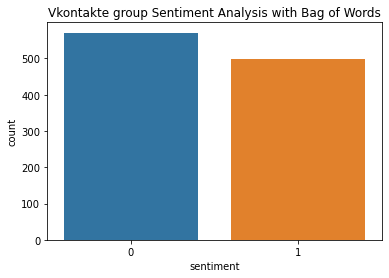

In [77]:
fig , ax = plt.subplots(figsize=(6,4))
sns.countplot(x='sentiment', data=RF_bow_output)
plt.title("Vkontakte group Sentiment Analysis with Bag of Words")
plt.show()

In [69]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))
        
RF_clf = RandomForestClassifier(verbose=2,
                                n_jobs=-1,
                                random_state = 42)

parameters = {
    'n_estimators': [5,10,50],
    'max_depth': [2,10,20,None]
}

cv = GridSearchCV(RF_clf, parameters)
cv.fit(bow_x_train, df_lemmatized_words["sentiment"])
print_results(cv)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.1s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent w

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaini

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    1.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:  

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.6min remaining:   40.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.7min remaining:   42.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.3min finished
[Parallel(n_j

building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50building tree 26 of 50

building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.4min


building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
BEST PARAMS: {'max_depth': None, 'n_estimators': 50}

0.506 (+/-0.004) for {'max_depth': 2, 'n_estimators': 5}
0.514 (+/-0.008) for {'max_depth': 2, 'n_estimators': 10}
0.555 (+/-0.004) for {'max_depth': 2, 'n_estimators': 50}
0.531 (+/-0.009) for {'max_depth': 10, 'n_estimators': 5}
0.554 (+/-0.01) for {'max_depth': 10, 'n_estimators': 10}
0.625 (+/-0.008) for {'max_depth': 10, 'n_estimators': 50}
0.552 (+/-0.02) for {'max_depth': 20, 'n_estimators': 5}
0.584 (+/-0.016) for {'max_depth': 20, 'n_estimators': 10}
0.647 (+/-0.01) for {'max_depth': 20, 'n_estimators': 50}
0.644 (+/-0.013) for {'max_depth'

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 10.4min finished


In [79]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 1, stop = 50, num = 5)]

max_features = ['auto', 'sqrt', 'log2']

max_depth = [int(x) for x in np.linspace(10, 100, num = 11)]
max_depth.append(None)

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,}

print(random_grid)

{'n_estimators': [1, 13, 25, 37, 50], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 19, 28, 37, 46, 55, 64, 73, 82, 91, 100, None]}


In [80]:
rf = RandomForestClassifier(random_state = 42, n_jobs=-1)

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

rf_random.fit(bow_x_train, df_lemmatized_words["sentiment"])

rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 49.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 101.0min finished


{'n_estimators': 50, 'max_features': 'sqrt', 'max_depth': 100}

In [81]:
rf_random.best_params_

{'n_estimators': 50, 'max_features': 'sqrt', 'max_depth': 100}

In [82]:
rf_random.cv_results_

{'mean_fit_time': array([  32.18856812,   11.09798058,  196.08418012,   98.28610198,
          17.02280124,   10.96300793,   41.04953329,   76.35376763,
         134.55775166,   48.45339632,  123.5315756 ,  272.6443975 ,
         120.58379451,  131.75158906,   15.41642904,   13.60161956,
          15.78943245,   15.71296922,   29.36944302,    8.37061008,
          65.75345635,   27.44558676,  169.48100781,   11.2372756 ,
          18.83594974, 1593.1982712 ,   20.86585299,   34.69785563,
          70.22582372, 2072.43075101,  255.42345874,   11.54146171,
          57.2947468 ,   94.14085714,   46.17781583,   21.34025176,
          45.94676534,   23.78271755,   77.53693636,   25.92066558,
           6.83404978,    8.0617969 ,  201.87738156,   12.50421913,
          33.74906047,   40.00532571,   27.36513503,   52.55708377,
        2713.74698416,   12.26884929,  878.1180679 ,  117.72919695,
          17.09792988, 1450.55712128,   37.52296368,   13.97528489,
         221.95779753,   86.191

In [67]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

# Random Forest Classifier на Word2Vec.

In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

RF_clf = RandomForestClassifier(n_estimators=50,
                                random_state=42,
                                max_depth = 100,
                                max_features = 'sqrt',
                                verbose=2,
                                n_jobs=7)

    
print("Fitting random forest to training data....")    
RF_w2v_clf = RF_clf.fit(np.nan_to_num(w2v_X_train), df_lemmatized_words["sentiment"])

Fitting random forest to training data....


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50


[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:  1.1min


building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=7)]: Done  50 out of  50 | elapsed:  1.9min finished


In [86]:
joblib.dump(RF_w2v_clf, 'RF_w2v_model.sav')

['RF_w2v_model.sav']

In [ ]:
RF_w2v_clf = joblib.load('RF_w2v_model.sav')

In [88]:
# Predicting the sentiment values for test data and saving the results in a csv file 
RF_w2v_result = RF_w2v_clf.predict(np.nan_to_num(w2v_X_test))
RF_w2v_output = pd.DataFrame(data={"comments":bd_lemmatized_words, "sentiment":RF_w2v_result})
RF_w2v_score = RF_w2v_clf.score(np.nan_to_num(w2v_X_train), df_lemmatized_words["sentiment"])
accuracy = accuracy_score(RF_w2v_output['sentiment'], RF_w2v_result)

#print(f'Out-of-bag score estimate: {RF_w2v_clf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
print(RF_w2v_score)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:    1.2s


Mean accuracy score: 1.0
0.9713374373453177


[Parallel(n_jobs=7)]: Done  50 out of  50 | elapsed:    2.2s finished


In [102]:
w2v_scores = cross_val_score(RF_clf, np.nan_to_num(w2v_X_train), df_lemmatized_words["sentiment"], cv=5)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   3 out of  10 | elapsed:   24.4s remaining:   57.2s
[Parallel(n_jobs=7)]: Done  10 out of  10 | elapsed:   36.0s finished
C:\Users\kamikaze666\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kamikaze666\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs

In [103]:
print(w2v_scores)
w2v_scores.mean()

[0.60904624 0.61716813 0.60637941 0.60155465 0.6006165 ]


0.6069529851181116

In [89]:
RF_w2v_output.to_csv("RF_w2v_output.csv", index=False, encoding='cp1251')

In [90]:
RF_w2v_output.head(20)

,comments,sentiment
0,"[толсто, аж, тонко, весело]",1
1,"[казаться, это, пародия, мойти, пайтон]",1
2,"[типичный, осада, железный, войнов, крепость, ...",1
3,"[просто, немного, унижение, железный, плакса]",1
4,[удивлённый],1
5,"[кто, интересно, читать, классно, осада, жв, о...",1
6,[перевод],1
7,"[юмор, весь, полок, смеяться]",0
8,[ересь],1
9,"[госпожа, комиссар, бдеть, дисциплина]",1


In [91]:
print((RF_w2v_output['sentiment'] == 0).sum(), '- negative comments')
print((RF_w2v_output['sentiment'] == 1).sum(), '- positive comments')

298 - negative comments
772 - positive comments


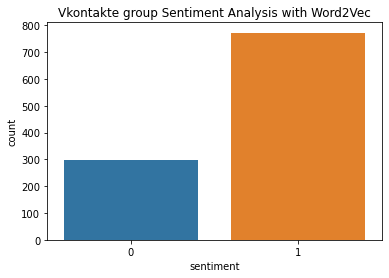

In [92]:
fig , ax = plt.subplots(figsize=(6,4))
sns.countplot(x='sentiment', data=RF_w2v_output)
plt.title("Vkontakte group Sentiment Analysis with Word2Vec")
plt.show()

# Random Forest Classifier на TF-IDF.

- Мы исследуем первые результаты классификатора Random Forest без какой-либо настройки гиперпараметров с использованием 5-кратной проверки.

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [78]:
RF_clf = RandomForestClassifier(n_estimators=50,
                                oob_score=True,
                                random_state=42,
                                verbose=2,
                                n_jobs=-1)

RF_tfidf_clf = RF_clf.fit(tfidf_vect_train, df_lemmatized_words["sentiment"])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.8min


building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  9.6min finished


In [79]:
joblib.dump(RF_tfidf_clf, 'RF_tfidf_model.sav')

['RF_tfidf_model.sav']

In [83]:
RF_tfidf_clf = joblib.load('RF_tfidf_model.sav')

In [100]:
RF_tfidf_result = RF_tfidf_clf.predict(tfidf_vect_test)
RF_tfidf_output = pd.DataFrame(data={"comments":bd_lemmatized_words, "sentiment":RF_tfidf_result})
RF_tfidf_score = RF_tfidf_clf.score(tfidf_vect_train, df_lemmatized_words["sentiment"])
accuracy = accuracy_score(RF_tfidf_output['sentiment'], RF_tfidf_result)

print(f'Out-of-bag score estimate: {RF_tfidf_clf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
print(RF_tfidf_score)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.2s


Out-of-bag score estimate: 0.708
Mean accuracy score: 1.0
0.9938797208795332


[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:   15.9s finished


In [ ]:
RF_tfidf_result = RF_tfidf_clf.predict(X_test)
#RF_tfidf_output = pd.DataFrame(data={"comments":bd_lemmatized_words, "sentiment":RF_tfidf_result})
RF_tfidf_score = RF_tfidf_clf.score(tfidf_vect_train, df_lemmatized_words["sentiment"])
accuracy = accuracy_score(RF_tfidf_output['sentiment'], RF_tfidf_result)

print(f'Out-of-bag score estimate: {RF_tfidf_clf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
print(RF_tfidf_score)

In [76]:
RF_tfidf_output.to_csv("RF_tfidf_output.csv", index=False, encoding='cp1251')

NameError: name 'RF_tfidf_output' is not defined

In [77]:
RF_tfidf_output.head(20)

NameError: name 'RF_tfidf_output' is not defined

In [82]:
print((RF_tfidf_output['sentiment'] == 0).sum(), '- negative comments')
print((RF_tfidf_output['sentiment'] == 1).sum(), '- positive comments')

433 - negative comments
637 - positive comments


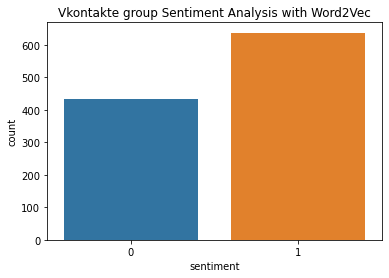

In [81]:
fig , ax = plt.subplots(figsize=(6,4))
sns.countplot(x='sentiment', data=RF_tfidf_output)
plt.title("Vkontakte group Sentiment Analysis with Word2Vec")
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))
        
RF_clf = RandomForestClassifier(verbose=2)

parameters = {
    'n_estimators': [5,10,50],
    'max_depth': [2,10,20,None]
}

cv = GridSearchCV(RF_clf, parameters)
cv.fit(X_train,y_train.values.ravel())
print_results(cv)

# Random Forest Classifier на Doc2Vec.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

RF_clf = RandomForestClassifier(n_estimators = 50,
                                oob_score=True,
                                random_state=42,
                                verbose=2)

print("Fitting random forest to training data....")    
RF_d2v_clf = RF_clf.fit(np.nan_to_num(trainDataVecs), df_lemmatized_words["sentiment"])

# Decision Tree Classifier на TF-IDF.

In [ ]:
from sklearn import tree
DTC_clf = tree.DecisionTreeClassifier(criterion='entropy',
                                      max_depth=200,
                                      random_state=42)

DTC_tfidf_clf = DTC_clf.fit(tfidf_vect_train, df_lemmatized_words["sentiment"].values.ravel()) 

In [ ]:
dtc_tfidf_result = DTC_tfidf_clf.predict(tfidf_vect_test)
dtc_tfidf_output = pd.DataFrame(data={"comments":bd_lemmatized_words, "sentiment":dtc_tfidf_result})
dtc_tfidf_score = DTC_tfidf_clf.score(tfidf_vect_train, df_lemmatized_words["sentiment"].values.ravel())

accuracy = accuracy_score(dtc_tfidf_output['sentiment'], dtc_tfidf_result)
print(f'Mean accuracy score: {accuracy:.3}')
print(dtc_tfidf_score)

In [ ]:
dtc_tfidf_output.to_csv("dtc_tfidf_output.csv", index=False, encoding='cp1251')
dtc_tfidf_output.head(20)

In [ ]:
print((dtc_tfidf_output['sentiment'] == 0).sum(), '- negative comments')
print((dtc_tfidf_output['sentiment'] == 1).sum(), '- positive comments')

In [ ]:
fig , ax = plt.subplots(figsize=(6,4))
sns.countplot(x='sentiment', data=dtc_tfidf_output)
plt.title("Vkontakte group Sentiment Analysis with TF-IDF")
plt.show()

# Multinomial Naive Bayes and Bag Of Words.

In [104]:
from sklearn.naive_bayes import MultinomialNB

In [140]:
MNB_clf = MultinomialNB(alpha=0.001)

In [141]:
MNB_bow_clf = MNB_clf.fit(bow_x_train, df_lemmatized_words["sentiment"])

In [142]:
MNB_bow_result = MNB_bow_clf.predict(bow_x_test)
MNB_bow_output = pd.DataFrame(data={"comments":bd_lemmatized_words, "sentiment":MNB_bow_result})
MNB_bow_score = MNB_bow_clf.score(bow_x_train, df_lemmatized_words["sentiment"])
accuracy = accuracy_score(MNB_bow_output['sentiment'], MNB_bow_result)

#print(f'Out-of-bag score estimate: {RF_bow_clf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
print(MNB_bow_score)

Mean accuracy score: 1.0
0.8120091491471816


In [143]:
print((MNB_bow_output['sentiment'] == 0).sum(), '- negative comments')
print((MNB_bow_output['sentiment'] == 1).sum(), '- positive comments')

415 - negative comments
655 - positive comments


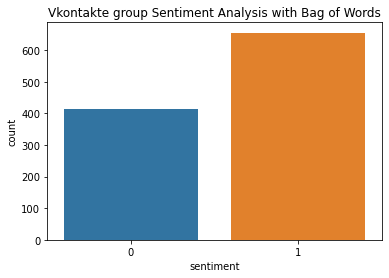

In [144]:
fig , ax = plt.subplots(figsize=(6,4))
sns.countplot(x='sentiment', data=MNB_bow_output)
plt.title("Vkontakte group Sentiment Analysis with Bag of Words")
plt.show()

In [145]:
MNB_bow_output.head(20)

,comments,sentiment
0,"[толсто, аж, тонко, весело]",1
1,"[казаться, это, пародия, мойти, пайтон]",0
2,"[типичный, осада, железный, войнов, крепость, ...",1
3,"[просто, немного, унижение, железный, плакса]",0
4,[удивлённый],1
5,"[кто, интересно, читать, классно, осада, жв, о...",1
6,[перевод],0
7,"[юмор, весь, полок, смеяться]",1
8,[ересь],1
9,"[госпожа, комиссар, бдеть, дисциплина]",1


# Multinomial Naive Bayes and TF-IDF.

MultinomialNB implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification (where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice).

In [146]:
from sklearn.naive_bayes import MultinomialNB
MNB_clf = MultinomialNB(alpha=0.01)
MNB_tfidf_clf = MNB_clf.fit(tfidf_vect_train, df_lemmatized_words["sentiment"])

In [147]:
MNB_tfidf_result = MNB_tfidf_clf.predict(tfidf_vect_test)
MNB_tfidf_output = pd.DataFrame(data={"comments":bd_lemmatized_words, "sentiment":MNB_tfidf_result})
MNB_tfidf_score = MNB_tfidf_clf.score(tfidf_vect_train, df_lemmatized_words["sentiment"])
accuracy = accuracy_score(MNB_tfidf_output['sentiment'], MNB_tfidf_result)

#print(f'Out-of-bag score estimate: {RF_bow_clf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
print(MNB_tfidf_score)

Mean accuracy score: 1.0
0.8157125881186172


In [148]:
print((MNB_tfidf_output['sentiment'] == 0).sum(), '- negative comments')
print((MNB_tfidf_output['sentiment'] == 1).sum(), '- positive comments')

424 - negative comments
646 - positive comments


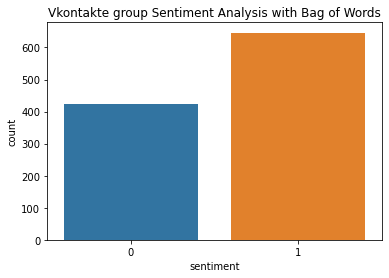

In [149]:
fig , ax = plt.subplots(figsize=(6,4))
sns.countplot(x='sentiment', data=MNB_tfidf_output)
plt.title("Vkontakte group Sentiment Analysis with Bag of Words")
plt.show()

In [150]:
MNB_tfidf_output.head(20)

,comments,sentiment
0,"[толсто, аж, тонко, весело]",1
1,"[казаться, это, пародия, мойти, пайтон]",1
2,"[типичный, осада, железный, войнов, крепость, ...",1
3,"[просто, немного, унижение, железный, плакса]",0
4,[удивлённый],1
5,"[кто, интересно, читать, классно, осада, жв, о...",1
6,[перевод],0
7,"[юмор, весь, полок, смеяться]",1
8,[ересь],1
9,"[госпожа, комиссар, бдеть, дисциплина]",1


# Multinomial Naive Bayes and Word2Vec.

In [156]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()
#w2v_X_train = scaler.fit(np.nan_to_num(w2v_X_train))

MNB_clf = MultinomialNB(alpha=0.01)
MNB_w2v_clf = MNB_clf.fit(w2v_X_train, df_lemmatized_words["sentiment"])

ValueError: Expected 2D array, got scalar array instead:
array=MinMaxScaler().
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

# Evaluating the models.

In [ ]:
vectorizers = [CountVectorizer, TFIDFVEctorizer, word2vec_vectorizer, doc2vec_vectorizer]
models = [RandomForestClassifier, ...]

def preprocess(initial_dataset): ...

    clean_posts = preprocess(initial_dataset)
    stemmed_words = ...
    lemmatized_words = ...

    param_grid = {RandomForestClassifier: RFC_grid} #наборы пааметров для данной модели
    # ключем может быть класс из sklearn а значением словарь параметров



normalized_corpuses = [stemmed_words, lemmatized_words]

def evaluate_model(model, X):
    evaluated_model = {"model": model} #значением может быть класс из sklearn
    # Создаем и фитим RandomSearchCV с учетом param_grid
    #добавляем best params  
    evaluated_model["best_param"] = best_params
    # Создаем модель с лучшими параметрами
    # обучаем моедль на X_train y_train
    # предсказываем на X_test
    # считаем метрики на предсказанных результатах и y_test
    evaluated_model["metric"] = metric
    # лучший результат добавляем в result

def evaluate_models(normalized_corpuses, vectorizers, models):
    evaluated_models = []
    for normalized_corpus in normalized_corpuses:
        X_train, X_test, y_train, y_test = train_test_split(...)
        for vectorizer in vectorizers:
            #  в идеале тут было бы просто vectorized_data = vectorizer.fit_transform(X_train)
            # но так как сейчас нету возможности так сделать для word2vec и doc2vec
            # то тут будет кастомная функция, например word2vec_vectorizer
            # которая будет делать преобазование в вектор по методу word2vec
            # и тут будет примерно следующее
            if vectorizer == word2vec_vectorizer:
                # получаем X_train, X_test, y_train, y_test через word2vec 
                # X_test и y_test на основе normalized_corpus скачанные данные не берем пока

            elif vectorizer == doc2vec_vectorizer:
                # получаем X_train, X_test, y_train, y_test через doc2vec 
            elif vectorizer in (CountVectorizer, TFIDFVEctorizer):
                # получаем X_train, X_test, y_train, y_test через соответствующий векторайзер 
            
            for model in models:
                evaluated_model = evaluate_model(model, X_train, X_test, y_train, y_test)
                evaluated_models.append(evaluated_model)
    return evaluated_models